In [211]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [264]:
import gzip
import json
from typing import Union
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
from pandarallel import pandarallel
from sklearn.metrics.pairwise import cosine_similarity
import plotly.graph_objects as go
from itertools import combinations,product
from networkx import from_pandas_edgelist
import networkx as nx
from matplotlib import pyplot as plt

In [238]:
pandarallel.initialize(progress_bar= True, nb_workers=7)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [320]:
%%time
def is_prime(x: Union[float, int]) -> bool:
    """Checks whether x is prime"""
    c=0
    for i in range(1,x//2+1):
        if (x%i == 0):
            c+=1
    if(c==1):
        return True
    else:
        return False
    raise NotImplementedError

#example
is_prime(37)

CPU times: user 16 µs, sys: 8 µs, total: 24 µs
Wall time: 26.2 µs


True

<h3>Process:</h3>
I have read the files and stored it in a dataframe called tab.<br>
I have further added a column which is title+ sep token + abstract called (title_abs) which i have used the tokenizee function  on and encoded.

In [4]:
# Implement your solution here
from transformers import AutoTokenizer, AutoModel

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
#stored the years to iterate over during file opening
years = os.listdir('/Users/ashmitamukherjee/Downloads/wos_sample')
del years[5]

In [7]:
tab = pd.DataFrame(columns=['item','abstract'])
for y in tqdm(years):
        for i in os.listdir('/Users/ashmitamukherjee/Downloads/wos_sample/'+str(y)+'/articles/'):
                try:
                        with gzip.open('/Users/ashmitamukherjee/Downloads/wos_sample/'+str(y)+'/articles/'+i, mode="rt") as f:
                                data = [json.loads(line) for line in f]
                                tab = pd.concat([tab, pd.DataFrame([(x['item'],x['abstract']) for x in data],columns= ['item','abstract'])])
                except:
                        print(i) 
tab = tab.reset_index(drop=True)

  0%|          | 0/23 [00:00<?, ?it/s]

.DS_Store


In [325]:
tab.head()

,item,abstract,title_abs
0,Divisional Managers and Internal Capital Markets,Using hand-collected data on divisional manage...,Divisional Managers and Internal Capital Marke...
1,Costs and Benefits of Requiring an Engagement ...,This paper investigates the effects on audit q...,Costs and Benefits of Requiring an Engagement ...
2,Externalities of public firm presence: Evidenc...,Public firms provide a large amount of informa...,Externalities of public firm presence: Evidenc...
3,Ratings quality over the business cycle,Credit rating agencies (CRAs) have long held t...,Ratings quality over the business cycle[SEP]Cr...
4,The inefficiency of refinancing: Why prepaymen...,This paper provides a theoretical analysis of ...,The inefficiency of refinancing: Why prepaymen...


In [9]:
#tab.loc[0,'item']+ tokenizer.sep_token + tab.loc[0,'abstract']
tab['title_abs'] = tab.progress_apply(lambda x: x['item']+ tokenizer.sep_token + x['abstract'],axis=1)

  0%|          | 0/9982 [00:00<?, ?it/s]

In [12]:
tab.to_csv('title_abs.csv')

In [324]:
def tokenizee(x):
    inputs = tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=512)
    result = model(**inputs)
    embeddings = result.last_hidden_state[:, 0, :]
    return embeddings

I have performed the encoding of title+abstract on gpu and loaded it as a csv which I have loaded directly into this notebook

In [14]:
embed_article = pd.read_csv('article_embeddings.csv')
embed_article

,Unnamed: 0,embed
0,0,[[-5.79088569e-01 3.89586806e-01 3.59572172e...
1,1,[[-7.96099007e-01 1.24426579e+00 -7.24435210e...
2,2,[[-1.13994789e+00 9.22040522e-01 -1.63122788e...
3,3,[[-1.88945755e-01 5.61711341e-02 -7.26393044e...
4,4,[[-1.85666382e-01 2.44334251e-01 -8.11811030e...
...,...,...
9977,9977,[[-7.53850877e-01 1.00360239e+00 -1.04655063e...
9978,9978,[[-4.95394439e-01 3.05652082e-01 -3.03048640e...
9979,9979,[[-2.62196034e-01 5.26279271e-01 -7.16772854e...
9980,9980,[[-6.98832989e-01 4.07206982e-01 -4.68128294e...


Each paper is associated with one or more authors. 

In [326]:
years = os.listdir('/Users/ashmitamukherjee/Downloads/wos_emb/')
del years[5] # this is the .DS store file

In [125]:
# Implement your solution here
wos_embed = pd.DataFrame(columns= ['doi','r_ids','embedding'])
for y in tqdm(years):
        for i in os.listdir('/Users/ashmitamukherjee/Downloads/wos_emb/'+str(y)+'/articles/'):
                try:
                        with gzip.open('/Users/ashmitamukherjee/Downloads/wos_emb/'+str(y)+'/articles/'+i, mode="rt") as f:
                                new = [json.loads(line) for line in f]
                                wos_embed = pd.concat([wos_embed, pd.DataFrame(new,columns= ['doi','r_ids','embedding'])])
                except:
                        continue


  0%|          | 0/23 [00:00<?, ?it/s]

In [131]:
wos_embed= wos_embed.explode('r_ids')
wos_embed['embedding'] = wos_embed['embedding'].apply(np.array)
wos_embed = wos_embed.reset_index(drop=True)

In [137]:
wos_embed
#loaded the predefined embed json files into a df

,index,doi,r_ids,embedding
0,0,10.1111/jofi.12003,GAH-2411-2022,"[-0.5790879726409912, 0.3895861506462097, 0.35..."
1,0,10.1111/jofi.12003,DTF-1860-2022,"[-0.5790879726409912, 0.3895861506462097, 0.35..."
2,1,10.2308/accr-50450,FYT-7113-2022,"[-0.7960996627807617, 1.2442651987075806, -0.7..."
3,1,10.2308/accr-50450,HNZ-7036-2023,"[-0.7960996627807617, 1.2442651987075806, -0.7..."
4,2,10.1016/j.jfineco.2013.03.012,IKE-2839-2023,"[-1.139947533607483, 0.9220395684242249, -0.16..."
...,...,...,...,...
20157,9,10.1111/j.1540-6261.2004.00695.x,HDR-5822-2022,"[-0.49539443850517273, 0.3056516647338867, -0...."
20158,9,10.1111/j.1540-6261.2004.00695.x,CVB-4643-2022,"[-0.49539443850517273, 0.3056516647338867, -0...."
20159,10,10.1016/S0304-405X(03)00182-X,ETB-4352-2022,"[-0.6988333463668823, 0.4072073996067047, -0.4..."
20160,10,10.1016/S0304-405X(03)00182-X,DEK-2059-2022,"[-0.6988333463668823, 0.4072073996067047, -0.4..."


In [ ]:
wos_embed[wos_embed['doi']=='10.1016/j.jacceco.2013.04.002']
# When the json was read, empty r_ids were creatd which need to be dropped

,doi,r_ids,embedding
7,10.1016/j.jacceco.2013.04.002,"[G-2748-2019, ]","[-0.8968008160591125, 0.40714409947395325, -0...."


In [136]:
wos_embed.drop(wos_embed.loc[wos_embed['r_ids']== ''].index, inplace= True)


In [179]:
id_embed_mean = wos_embed.groupby('r_ids')['embedding'].mean()

Creating a recommender system which provides the top 20 authors related to a Professor

In [283]:
aut = pd.DataFrame(columns=['full_name','r_id'])
for y in tqdm(years):
        for i in os.listdir('/Users/ashmitamukherjee/Downloads/wos_sample/'+str(y)+'/authors/'):
                try:
                        with gzip.open('/Users/ashmitamukherjee/Downloads/wos_sample/'+str(y)+'/authors/'+i, mode="rt") as f:
                                data = [json.loads(line) for line in f]
                                aut = pd.concat([aut, pd.DataFrame([(x['full_name'],x['r_id']) for x in data],columns= ['full_name','r_id'])])
                except Exception as e:
                        print(e)
                        
aut = aut.reset_index(drop=True)

  0%|          | 0/23 [00:00<?, ?it/s]

Not a gzipped file (b'\x00\x00')


In [284]:
aut
# author to id mapping

,full_name,r_id
0,"Singh, Anil K.",M-4786-2017
1,"Zhang, Ya-Fei",JBD-8523-2023
2,"Yu, Miao",HRC-0342-2023
3,"Wagner, Christian",H-6310-2012
4,"Cesarini, David",JDD-2467-2023
...,...,...
177635,"Inderst, R",FBX-2621-2022
177636,"Anderson, CW",GXC-3417-2022
177637,"Becher, DA",CFO-8230-2022
177638,"Hirtle, B",EYS-2636-2022


In [189]:
uudf= pd.DataFrame(cosine_similarity(np.stack(id_embed_mean.values)),index=id_embed_mean.index,columns= id_embed_mean.index)
# author-author similarity matrix for finding the top 20 related authors to Prof Costello

In [229]:
uudf

r_ids,A-1038-2007,A-1096-2010,A-1124-2014,A-1134-2007,A-1143-2007,A-1280-2007,A-1298-2011,A-1972-2019,A-1983-2017,A-2161-2015,...,X-9770-2019,Y-1183-2019,Y-3419-2018,Y-5134-2019,Y-5715-2019,Y-7624-2019,Y-8756-2018,Y-8942-2019,Z-1704-2019,Z-3453-2019
r_ids,,,,,,,,,,,,,,,,,,,,,
A-1038-2007,1.000000,0.926321,0.946334,0.874786,0.905519,0.945177,0.937413,0.955767,0.814896,0.882988,...,0.864465,0.800823,0.849556,0.912143,0.853514,0.878079,0.836233,0.891061,0.928678,0.776492
A-1096-2010,0.926321,1.000000,0.923153,0.819954,0.883765,0.907834,0.926922,0.933548,0.816064,0.803362,...,0.851891,0.802751,0.767279,0.889427,0.783646,0.840671,0.839637,0.893264,0.868380,0.768217
A-1124-2014,0.946334,0.923153,1.000000,0.898421,0.906363,0.952195,0.952213,0.953761,0.818086,0.832080,...,0.841008,0.809713,0.796089,0.885211,0.801589,0.899336,0.886676,0.909803,0.885426,0.795569
A-1134-2007,0.874786,0.819954,0.898421,1.000000,0.842158,0.878500,0.886275,0.863029,0.745245,0.843362,...,0.769489,0.737092,0.736800,0.775995,0.815135,0.848898,0.832532,0.865300,0.813094,0.790898
A-1143-2007,0.905519,0.883765,0.906363,0.842158,1.000000,0.906007,0.944149,0.932440,0.916198,0.882579,...,0.839722,0.898628,0.818410,0.830668,0.866220,0.833217,0.805263,0.923440,0.869853,0.729869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y-7624-2019,0.878079,0.840671,0.899336,0.848898,0.833217,0.864065,0.851821,0.890849,0.740940,0.757162,...,0.854674,0.737789,0.708574,0.791177,0.783740,1.000000,0.830046,0.825493,0.829055,0.690284
Y-8756-2018,0.836233,0.839637,0.886676,0.832532,0.805263,0.839357,0.852047,0.865508,0.701461,0.764664,...,0.757992,0.674486,0.675988,0.769331,0.722809,0.830046,1.000000,0.837777,0.757164,0.729913
Y-8942-2019,0.891061,0.893264,0.909803,0.865300,0.923440,0.901959,0.956428,0.918292,0.852062,0.857871,...,0.820853,0.850192,0.739846,0.819888,0.784178,0.825493,0.837777,1.000000,0.813308,0.794520


In [190]:
author = 'IXO-1320-2023'

In [327]:
aList = uudf.loc[:,author].sort_values(ascending=False)[1:21].index
aList
#top 20 authors by r_ids

Index(['GCZ-2358-2022', 'FJF-5746-2022', 'GXO-8275-2022', 'F-2424-2018',
       'GJI-2443-2022', 'CWX-5620-2022', 'HIR-3827-2022', 'BBD-9657-2022',
       'CIW-5969-2022', 'GFM-7827-2022', 'DZN-1080-2022', 'ETQ-5061-2022',
       'JTL-7880-2023', 'FTM-7947-2022', 'DWN-1634-2022', 'EOB-9202-2022',
       'CRE-9542-2022', 'CKQ-3248-2022', 'JQM-6488-2023', 'HOO-9717-2023'],
      dtype='object', name='r_ids')

In [306]:
aComb = product(['IXO-1320-2023'],aList)
nxdf = pd.DataFrame(aComb)
nxdf['Distance_from_author'] = nxdf.parallel_apply(lambda x: 1-uudf.at[x[0],x[1]],axis = 1)
# creatng the graph network. the distances are (1- similarity score) so the most similar are the closest in the graph.

Graph demo: Also went ahead and created a graph demo using networkX of top 20 authors similar to Prof. Costello

In [307]:
nxdf[1] = nxdf[1].progress_apply(lambda x: aut[aut['r_id'] == x]['full_name'].iloc[0])
nxdf[0] = 'Anna Costello'
nxdf

  0%|          | 0/20 [00:00<?, ?it/s]

,0,1,Distance_from_author
0,Anna Costello,"Beatty, Anne",0.022833
1,Anna Costello,"Liao, Scott",0.023342
2,Anna Costello,"Weber, Joseph",0.026220
3,Anna Costello,"Dou, Yiwei",0.026221
4,Anna Costello,"Wittenberg-Moerman, Regina",0.028057
5,Anna Costello,"James, Christopher M.",0.031698
6,Anna Costello,"Ryan, Stephen G.",0.031955
7,Anna Costello,"Ertan, Aytekin",0.032202
8,Anna Costello,"Bushman, Robert M.",0.032270
9,Anna Costello,"Nicoletti, Allison",0.034665


In [ ]:
(uudf.loc[:,author].sort_values(ascending=False)[1:21].to_frame()).reset_index().set_index(nxdf[1].values).style.background_gradient(cmap="Greys")
# answer in table form

,r_ids,IXO-1320-2023
"Beatty, Anne",GCZ-2358-2022,0.977167
"Liao, Scott",FJF-5746-2022,0.976658
"Weber, Joseph",GXO-8275-2022,0.973780
"Dou, Yiwei",F-2424-2018,0.973779
"Wittenberg-Moerman, Regina",GJI-2443-2022,0.971943
"James, Christopher M.",CWX-5620-2022,0.968302
"Ryan, Stephen G.",HIR-3827-2022,0.968045
"Ertan, Aytekin",BBD-9657-2022,0.967798
"Bushman, Robert M.",CIW-5969-2022,0.967730
"Nicoletti, Allison",GFM-7827-2022,0.965335


In [308]:
G = from_pandas_edgelist(nxdf,0,1,['Distance_from_author'])

<function matplotlib.pyplot.show(close=None, block=None)>

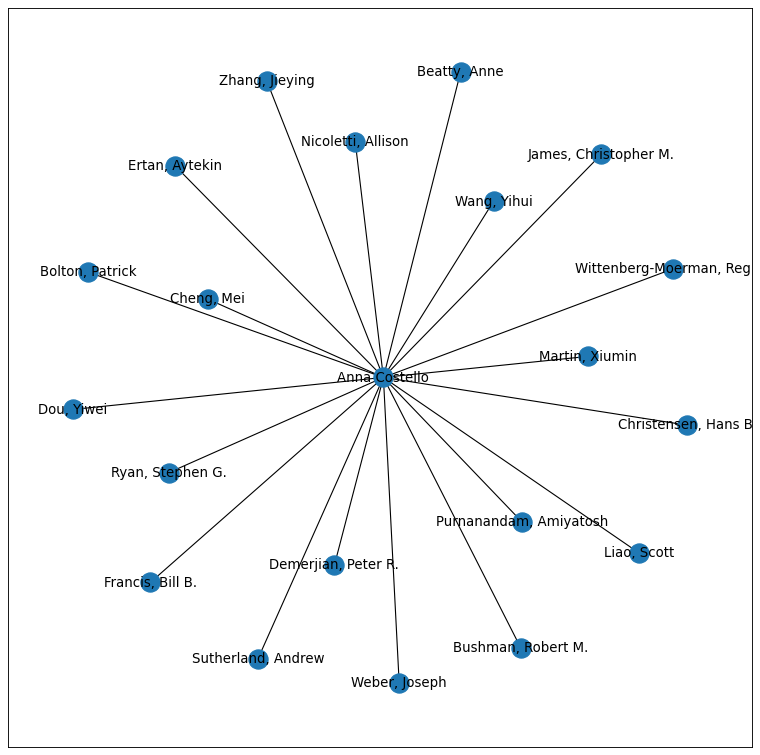

In [309]:
plt.figure(figsize=(12, 12), dpi=80)
nx.draw_networkx(G)
plt.show
# answer in graph form. 

I have tried to optimise every step of the solution by using multiprocessing and minimizing time complexity wherever i could. I have created a mini recommendation system dataframe for the implementation and also shown the solution in 2 forms.